In [40]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [41]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Loading objects from a Joblib

In [42]:
## Load the joblib file stored in the models folder
fname = "best-models.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'linear Regression', 'RandomForest'])

In [43]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
lin_reg = loaded['linear Regression']
loaded_model = loaded['RandomForest']

In [44]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)

Split,R^2,MAE,RMSE
Train,0.94,302.39,436.59
Test,0.53,786.24,"1,132.81"


In [45]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [46]:
len(X_train_df)

6392

In [47]:
# Take a sample of the training data (nsampel=800, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 800,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Item_Weight,Item_MRP,Item_Fat_Content_regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
3888,15.85,36.9506,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2497,15.10,221.8456,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7723,17.50,184.8266,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8117,10.80,243.2144,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7475,15.00,140.4838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Explaining Our RandomForest

In [48]:
#1. Create a SHAP explainer using your fit model
explainer = shap.Explainer(loaded_model)
explainer

In [49]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [52]:
X_shap.shape

(800, 35)

In [53]:
shap_values.shape

(800, 35)

In [54]:
shap_values[0]

.values =
array([-7.31267936e+00, -1.67476171e+03,  6.78205134e+00, -4.41680509e-01,
       -8.82287672e-01, -1.32049671e+00,  1.51724039e+00,  2.48387419e+01,
       -2.50651825e+00, -7.82746574e-01, -8.55104733e+00, -6.57848888e-01,
       -1.39364825e+00, -8.67453989e-01, -1.28498424e+00, -1.56945984e+00,
       -3.19255296e+00,  3.27203108e+00, -1.17209772e+00,  2.59096401e+01,
       -2.73952795e+01,  3.38953238e+00, -4.62280027e+01,  6.33289098e-01,
        9.12304376e+00,  2.14228883e+00, -8.76734086e-01, -5.34105347e+00,
       -2.20902315e+01,  4.36604905e+00, -3.45584293e+00, -7.26129455e-01,
        2.41887881e+02, -2.24451430e+01, -5.57773008e+01])

.base_values =
array([2207.5242624])

.data =
array([15.85  , 36.9506,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,
    

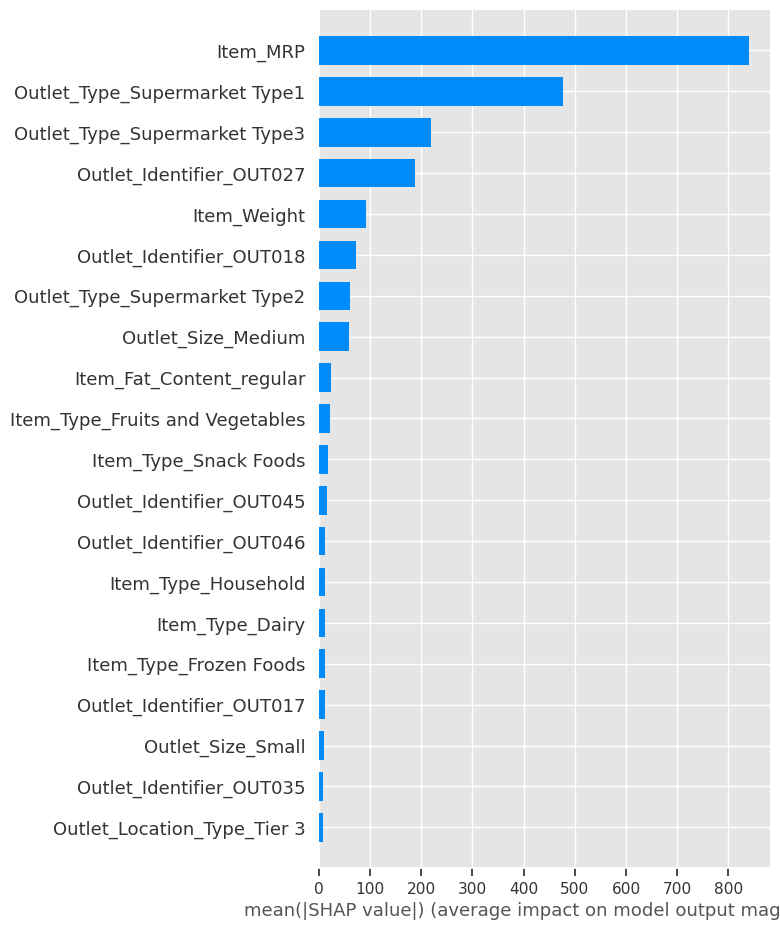

In [56]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


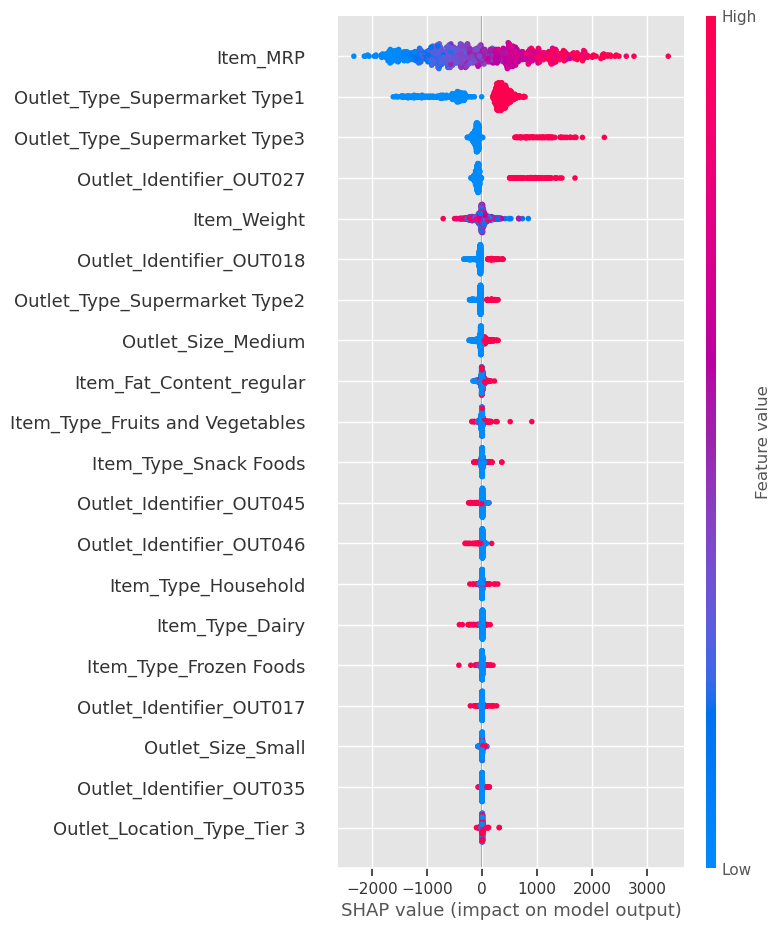

In [57]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

<img src="importances.png" width=60%>

in the shap plot item_mrp is the top important feature just as plot of important features so is outlet_type_supermarket type1 but in shap plots the most important 3rd feature is outlet_type_3 but in the plot of original feature importances figure the third important is item_weight and then the next important is out_let identifier_out027 where as in the feature important role, it is the last important feature from the 5 most important feature.outlet_type_supermarket type1 ,outlet_type_3  and outlet_identifier_OUT027 show that the higher their values the higher the model is going to predict the sales so they are most important features for predicting sales in shap where as in feature importances plot item_mrp, outlet type supermarket type 1, item weight and the others follow.

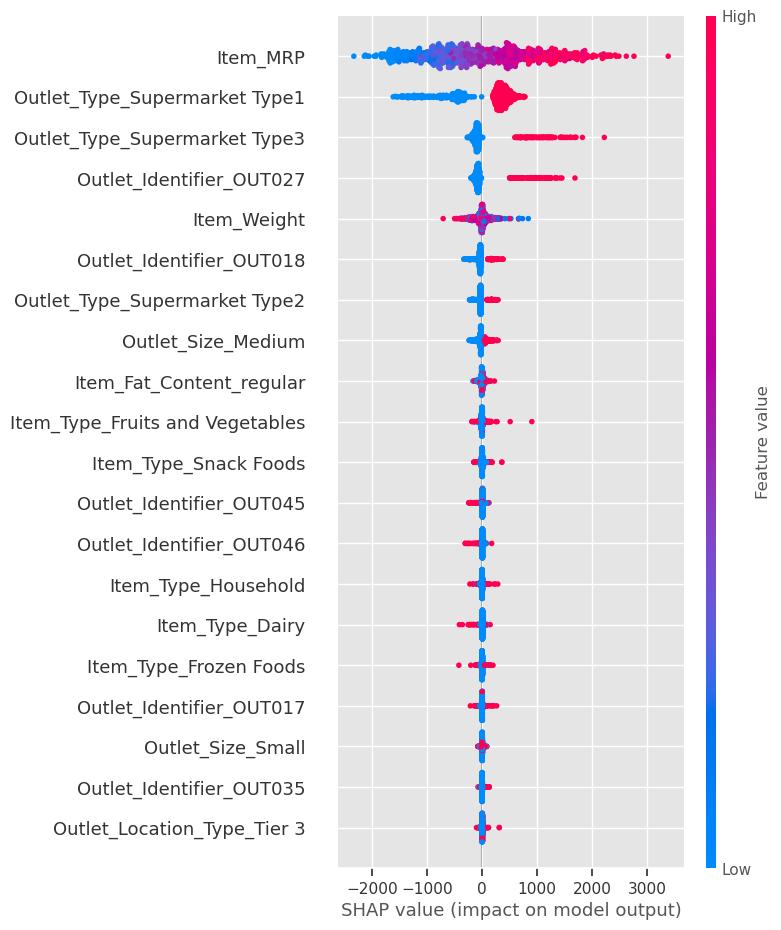

In [58]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='dot')

# Interpreting the SHAP values for our model:
 
  ## ITEM_MRP
    
  since positive values are on the right, we can see that the greater the number of ITEM_MRP , the more likely the model would predict the sales .we see that at the left, the blue values, for the lower  values of ITEM_MRP, the less likely the model will predict the sales that is towards the left.The lowest the values of the ITEM_MRP the less chance it will pridicting  the sales.so the higher values of the item_mrp the more likely it's going to pridict the sales.

## outlet_type_supermartket_type1

since the red value is on the right, the more the values of outlet_type_supermarket_type1, the more likely it is going to predict the sales

## outlet_type_supermartket_type3

In here also, the more the values of the ourtlet_type_supermarket_type3, the more chances of predicting the sales.( direct relation)